In [1]:
require 'VGG';
require 'nn';

In [2]:
-- require 'VGG';
-- VGG_net = load_VGG();
-- print('VGGnet5\n' .. VGG_net:__tostring());

In [3]:
-- local layer_nums = {9,16}
-- local num_images = 20;
-- hc_dataset = create_hypercolumn_dataset(num_images, layer_nums)

##  Loading the data from disk

In [4]:
hc_file_name = '../../Data/tiny-imagenet-200/test/hc/test.t7'
hc_dataset = torch.load(hc_file_name)

In [5]:
hypercolumns = hc_dataset["hypercolumns"]
images = hc_dataset["images"]
print(hypercolumns:size())
num_hypercolumns = hypercolumns:size()[2]
batch_size = hypercolumns:size()[1]

   4
 192
 112
 112
[torch.LongStorage of size 4]



## Converting the data labels from rgb to uv format

In [6]:
local yuv_temp = image.rgb2yuv(images[1]);
yuv_temp = image.scale(yuv_temp,28,28,'bilinear')
local uv_temp = yuv_temp[{{2,3}}]
local y_temp = yuv_temp[{{1}}]
uv_temp = uv_temp:reshape(1,uv_temp:size()[1], uv_temp:size()[2], uv_temp:size()[3] );
y_temp = y_temp:reshape(1,y_temp:size()[1], y_temp:size()[2], y_temp:size()[3] );
uv_images = uv_temp +0.5
y_images = y_temp

for count=2,batch_size do
    yuv_temp = image.rgb2yuv(images[count]);
    yuv_temp = image.scale(yuv_temp,28,28,'bilinear')
    uv_temp = yuv_temp[{{2,3}}]
    y_temp = yuv_temp[{{1}}]
    
    uv_temp = uv_temp:reshape(1,uv_temp:size()[1], uv_temp:size()[2], uv_temp:size()[3]) + 0.5;
    y_temp = y_temp:reshape(1,y_temp:size()[1], y_temp:size()[2], y_temp:size()[3] );
    
    uv_images = torch.cat(uv_images,uv_temp,1)
    y_images = torch.cat(y_images,y_temp,1)
end
    print(uv_images:size())

  4
  2
 28
 28
[torch.LongStorage of size 4]



## Initializing the trainset datastructure.
The format should be as follows
1) Trainset.data = contains **X minibatches**

In [7]:
print(y_images:size())

  4
  1
 28
 28
[torch.LongStorage of size 4]



In [8]:
trainset={};
trainset.data = torch.Tensor(1, hypercolumns:size()[1],hypercolumns:size()[2],hypercolumns:size()[3],hypercolumns:size()[4])
trainset.label = torch.Tensor(1,uv_images:size()[1],uv_images:size()[2],uv_images:size()[3],uv_images:size()[4])
function trainset:size() return hypercolumns:size()[1] end -- 100 examples
for i=1,trainset:size() do 
  trainset.data[1][i] = hypercolumns[i]
  trainset.label[1][i] = uv_images[i] 
end

setmetatable(trainset, 
    {__index = function(t, i) 
                    return {t.data[i], t.label[i]} 
                end}
);
trainset.data = trainset.data:double() -- convert the data from a ByteTensor to a DoubleTensor.

function trainset:size() 
    return self.data:size(1) 
end

In [9]:
require "nn"
require "torch"

function BasicConvNet1()
    -- Number of filters in different layers 
    net = nn.Sequential()
    HyperColumnHeight = num_hypercolumns
    Layer1FilterNum = 32
    Layer2FilterNum = 64
    Layer3FilterNum = 2


    -- [[ Layer 1 ]]
    -- HyperColumnHeight input image channel, Layer1FilterNum output channels, 3x3 convolution kernel, 1 stride W, 1 stride H, 1 pad W, 1 pad R
    net:add(nn.SpatialConvolution(HyperColumnHeight, Layer1FilterNum, 3, 3, 1, 1, 1, 1)) 
    -- Batch Normalization
    net:add(nn.SpatialBatchNormalization(Layer1FilterNum))                       
    -- ReLU non-linearity
    net:add(nn.ReLU())
    -- 2x2 max-pooling
    net:add(nn.SpatialMaxPooling(2,2,2,2))


    -- [[ Layer 2 ]]
    -- Layer1FilterNum input image channel, Layer2FilterNum output channels, 3x3 convolution kernel, 1 stride W, 1 stride H, 1 pad W, 1 pad R
    net:add(nn.SpatialConvolution(Layer1FilterNum, Layer2FilterNum, 3, 3, 1, 1, 1, 1)) 
    -- Batch Normalization
    net:add(nn.SpatialBatchNormalization(Layer2FilterNum))                       
    -- ReLU non-linearity
    net:add(nn.ReLU())
    -- 2x2 max-pooling
    net:add(nn.SpatialMaxPooling(2,2,2,2))

    --[[ Layer 3 ]]
    -- Layer2FilterNum input image channel, Layer3FilterNum output channels, 3x3 convolution kernel, 1 stride W, 1 stride H, 1 pad W, 1 pad R
    net:add(nn.SpatialConvolution(Layer2FilterNum, Layer3FilterNum, 3, 3, 1, 1, 1, 1)) 
    -- Adding transfer function sigmod 
    net:add(nn.Sigmoid())  

    net:zeroGradParameters()
    return net

end


In [10]:
require "nn"
require "torch"

function BasicConvNet2()
    -- Number of filters in different layers 
    net = nn.Sequential()
    HyperColumnHeight = num_hypercolumns
    Layer1FilterNum = 32
    Layer2FilterNum = 64
    Layer3FilterNum = 2


    -- [[ Layer 1 ]]
    -- HyperColumnHeight input image channel, Layer1FilterNum output channels, 3x3 convolution kernel, 1 stride W, 1 stride H, 1 pad W, 1 pad R
    net:add(nn.SpatialConvolution(HyperColumnHeight, Layer1FilterNum, 3, 3, 1, 1, 1, 1)) 
    -- Batch Normalization
    net:add(nn.SpatialBatchNormalization(Layer1FilterNum))                       
    -- ReLU non-linearity
    net:add(nn.ReLU())
    
    net:add(nn.SpatialConvolution(Layer1FilterNum, Layer1FilterNum, 3, 3, 1, 1, 1, 1)) 
    -- Batch Normalization
    net:add(nn.SpatialBatchNormalization(Layer1FilterNum))                       
    -- ReLU non-linearity
    net:add(nn.ReLU())
    
    net:add(nn.SpatialConvolution(Layer1FilterNum, Layer1FilterNum, 3, 3, 1, 1, 1, 1)) 
    -- Batch Normalization
    net:add(nn.SpatialBatchNormalization(Layer1FilterNum))                       
    -- ReLU non-linearity
    net:add(nn.ReLU())
    
    -- 2x2 max-pooling
    net:add(nn.SpatialMaxPooling(2,2,2,2))


    -- [[ Layer 2 ]]
    -- Layer1FilterNum input image channel, Layer2FilterNum output channels, 3x3 convolution kernel, 1 stride W, 1 stride H, 1 pad W, 1 pad R
    net:add(nn.SpatialConvolution(Layer1FilterNum, Layer2FilterNum, 3, 3, 1, 1, 1, 1)) 
    -- Batch Normalization
    net:add(nn.SpatialBatchNormalization(Layer2FilterNum))                       
    -- ReLU non-linearity
    net:add(nn.ReLU())
    
     net:add(nn.SpatialConvolution(Layer2FilterNum, Layer2FilterNum, 3, 3, 1, 1, 1, 1)) 
    -- Batch Normalization
    net:add(nn.SpatialBatchNormalization(Layer2FilterNum))                       
    -- ReLU non-linearity
    net:add(nn.ReLU())
    
     net:add(nn.SpatialConvolution(Layer2FilterNum, Layer2FilterNum, 3, 3, 1, 1, 1, 1)) 
    -- Batch Normalization
    net:add(nn.SpatialBatchNormalization(Layer2FilterNum))                       
    -- ReLU non-linearity
    net:add(nn.ReLU())
    -- 2x2 max-pooling
    net:add(nn.SpatialMaxPooling(2,2,2,2))

    --[[ Layer 3 ]]
    -- Layer2FilterNum input image channel, Layer3FilterNum output channels, 3x3 convolution kernel, 1 stride W, 1 stride H, 1 pad W, 1 pad R
    net:add(nn.SpatialConvolution(Layer2FilterNum, Layer3FilterNum, 3, 3, 1, 1, 1, 1)) 
    -- Adding transfer function sigmod 
    net:add(nn.Sigmoid())  

    net:zeroGradParameters()
    return net

end

In [11]:
-- require('Net1')

In [46]:
-- Loading the net
net = BasicConvNet1()
net:zeroGradParameters()
-- net = BasicConvNet2()

print('ConvNet Loaded')

-- Defining a loss function
-- Weight = torch.ones(2,28,28)-- All ones matrix -- Bad coding
criterion = nn.MSECriterion()
print('MSEcriterion defined')

trainer = nn.StochasticGradient(net, criterion)
-- learning rate init
trainer.learningRate = .5 -- This can be further increased
-- Number of Epocs
trainer.maxIteration = 20
trainer.verbose = true
trainer.shuffleIndices = false
trainer.learningRateDecay = .8
print('Trainer defined')

ConvNet Loaded	
MSEcriterion defined	
Trainer defined	


In [47]:
-- Passing a random input
input = torch.rand(2,192,112,112) -- pass a random tensor as input to the network
-- Obtain the output
output = net:forward(input)

-- Checking the backward pass using a fake expected output
ExpectedFakeOutput = torch.rand( output:size() )
criterion:forward(output, ExpectedFakeOutput)
gradients = criterion:backward(output, ExpectedFakeOutput)
print("No code error during sanity check (Logical error might still exist)")

No code error during sanity check (Logical error might still exist)	


In [48]:
require 'copy'
prev_net = copy3(net)

## Network output before training

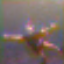

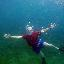

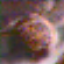

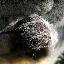

In [49]:
require 'copy'
a = copy3(prev_net:forward(hypercolumns))
i = 1
itorch.image(image.scale(image.yuv2rgb(torch.cat(y_images[i],a[i]-0.5,1)), 64,64))
itorch.image(images[i] )

print('\n')
i = 4
itorch.image(image.scale(image.yuv2rgb(torch.cat(y_images[i],a[i]-0.5,1)), 64,64))
itorch.image(images[i] )



In [50]:
print('The training starts')
-- Woah! Traingin the data
trainer:train(trainset)
--torch.save('../Models/Overfit', net)

The training starts	
# StochasticGradient: training	


# current error = 0.020477421616646	


# current error = 0.036849877893807	


# current error = 0.0056489512044499	


# current error = 0.003089467409495	


# current error = 0.0028949039331617	


# current error = 0.0027766130590624	


# current error = 0.0026910463968158	


# current error = 0.0026244071516613	


# current error = 0.0025696926905768	


# current error = 0.002523717975579	


# current error = 0.0024842617457318	


# current error = 0.0024496079787851	


# current error = 0.0024189901891982	


# current error = 0.0023916503582211	


# current error = 0.0023668441521253	


# current error = 0.0023442492324331	


# current error = 0.0023235339040623	


# current error = 0.0023043990523058	


# current error = 0.0022866779988875	


# current error = 0.0022701583856953	
# StochasticGradient: you have reached the maximum number of iterations	
# training error = 0.0022701583856953	


In [51]:
b = net:forward(hypercolumns)


In [52]:
 --print(uv_images[1])
--print(b)

Apna	


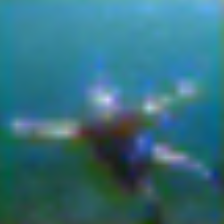

Asli	


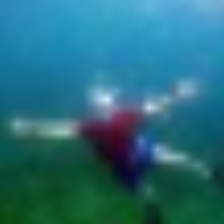

Apna	


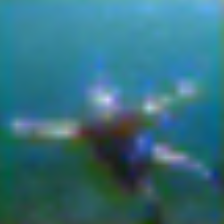

Asli	


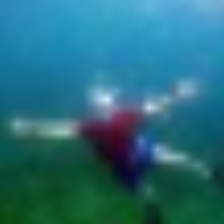

Apna	


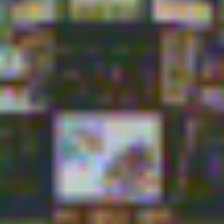

Asli	


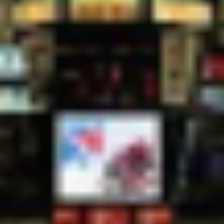

Apna	


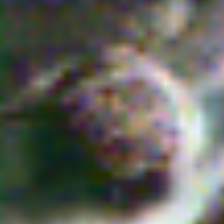

Asli	


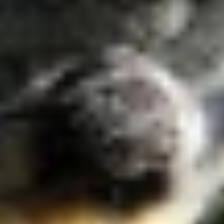

In [53]:
scale = 224
for i=1,4 do    
    print('\n')
    A = image.scale(image.yuv2rgb(torch.cat(y_images[i],a[i]-0.5,1)), scale,scale)
    C = image.scale(image.yuv2rgb(torch.cat(y_images[i],uv_images[i] -0.5,1)), scale,scale)
    print('Apna')
    itorch.image(A)
    print('Asli')
    itorch.image(C)
end